# 1/ Random Forest Classifier on Bollinger Bands Strategy

This part includes 2 steps:

1. Calculate Bollinger Bands and create signals (sell at the up cross and buy at the down cross)
    
2. Training RF classifier on the BB signals. Data used is 1 minute candles, the training set is 24 hours data, and validation set is 8 hours data
    
Accuracy analysis incluces: ROC curve, confusion matrix and classification report.

One can replace RF classifier by Gradient Boosting Tree classifier, or Recurrent Neural Network,... The rest of this script can be kept the same.

In [1]:
import warnings
warnings.simplefilter("ignore")
import os, sys, time
from datetime import datetime
from ultilities import timestr
from indicators import OBVol, MACD, Williams, StochOsc, RSIfunc, Bbands, average_true_range
from tradingpy import Backtester, Signal, SIDE
PY3 = sys.version_info[0] == 3
PY2 = sys.version_info[0] == 2
if PY3: _pip = 'pip3'
else: _pip = 'pip'
    
import numpy as np
import pandas as pd
try:
    import matplotlib.pyplot as plt
except:
    print('\tmatplotlib is missing. Please install by: \" {} install matplotlib \" '.format(_pip))

try:
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, roc_curve, auc
    from sklearn.feature_selection import SelectFromModel
    from sklearn.pipeline import Pipeline
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
except:
    print('\tsklearn is missing. Please install by: \" {} install sklearn \" '.format(_pip))

try:
    from statsmodels.tsa.stattools import coint, adfuller
except:
    print('\tstatsmodels is missing. Please install by: \" {} install statsmodels \" '.format(_pip))
    
try:
    from scipy.stats import pearsonr
except:
    print('\tstatsmodels is missing. Please install by: \" {} install statsmodels \" '.format(_pip))

plt.rcParams.update({'font.size': 20})
plt.rcParams.update({"hist.bins": 200})

In [2]:
# Read candles and ticks data from filepath
filepath_tik = 'data/ticks/' 
filepath_kln = 'data/klines/'
symbol = 'BCHUSDT'
kl_size = '1m'
pd_tn, pd_vd = int(24*60), int(8*60)
pd_es = 15
klns = pd.read_csv(filepath_kln + "-%s-%s.csv" % (symbol, kl_size), index_col=0).iloc[:(pd_tn+pd_vd)]
aggs = pd.read_csv(filepath_tik + "aggtrades-%s.csv" % (symbol), index_col=0)
test_start = aggs['_t'].searchsorted(klns['_t'].iloc[0])
test_end = aggs['_t'].searchsorted(klns['_t'].iloc[-1])
aggs = aggs.iloc[test_start:test_end]

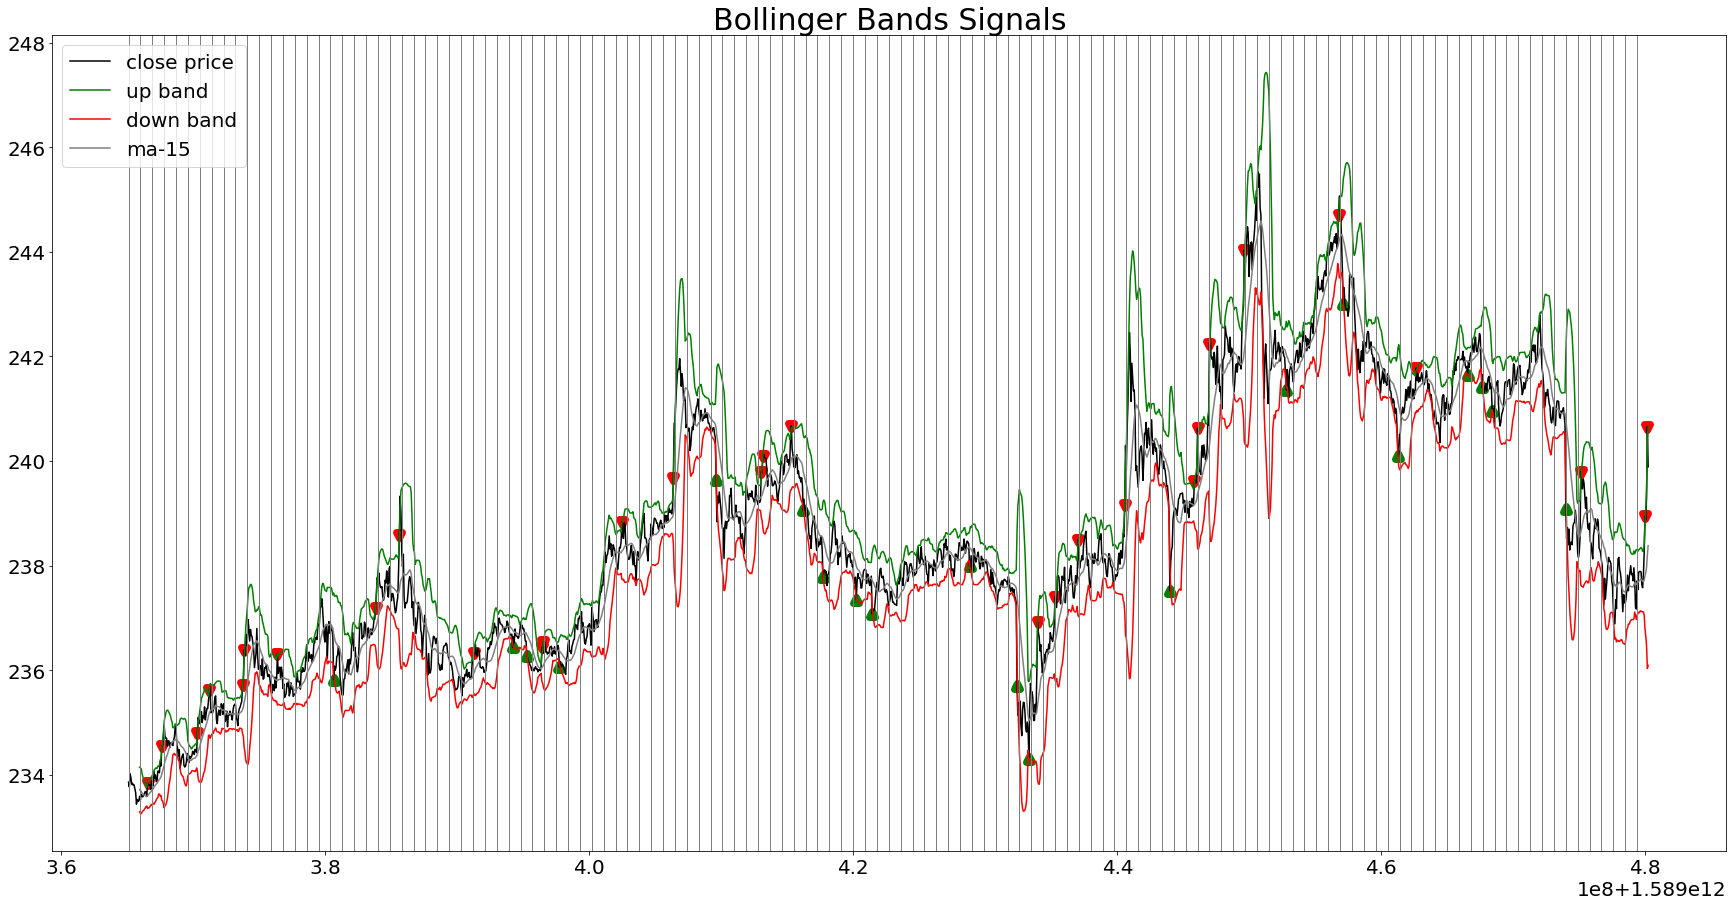

In [3]:
# Calculate bollinger bands, plot the results
wd, sd = pd_es, 2.5
ave, bb_up, bb_down = Bbands(klns['_c'], window=wd, numsd=sd)
# up cross
crit1 = klns['_c'].shift(1) < bb_up.shift(1)
crit2 = klns['_c'] > bb_up
up_cross = klns[crit1 & crit2]
# down cross
crit1 = klns['_c'].shift(1) > bb_down.shift(1)
crit2 = klns['_c'] < bb_down
dn_cross = klns[crit1 & crit2]

klns['side'] = np.zeros(klns.shape[0])
klns.loc[up_cross.index, 'side'] = -1.
klns.loc[dn_cross.index, 'side'] = 1.

# Plot Bollinger Bands Signals
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.set_title('Bollinger Bands Signals', fontsize=30)
ax.plot(klns['_t'], klns['_c'], label='close price', color='black')
ax.plot(klns['_t'], bb_up, label='up band', color='green')
ax.plot(klns['_t'], bb_down, label='down band', color='red')
ax.plot(klns['_t'], ave, label='ma-%d' % wd, color='grey')
ax.scatter(up_cross['_t'], up_cross['_c'], marker='v', color='r', linewidths=7)
ax.scatter(dn_cross['_t'], dn_cross['_c'], marker='^', color='g', linewidths=7)
for i in range(0, klns.shape[0], pd_es):
    ax.axvline(x=klns['_t'].iloc[i], linewidth=1, color='grey')
ax.legend(loc=2, prop={'size': 20})

In [4]:
# Construct features
klns['rsi'] = RSIfunc(klns, period=pd_es)
klns['sto'] = StochOsc(klns, period=pd_es)
klns['wlm'] = Williams(klns, period=pd_es)
klns['mac'] = MACD(klns, fpd=pd_es, spd=2*pd_es)
klns['pct'] = (klns['_c'] - klns['_c'].shift(pd_es))/klns['_c'].shift(pd_es)
klns['obv'] = OBVol(klns)

feats = [ 'rsi', 'sto', 'wlm', 'mac', 'obv', 'pct']

In [5]:
# Setup training/validation data for Random Forest Classifier
klns_tn = klns.iloc[:pd_tn]
data_tn = klns_tn[klns_tn['side'] != 0].copy()

# Calculate average true range based on training period
atr, atr_pct = average_true_range(klns_tn, period=pd_es, alpha=0.3, highlow=False)

# Forming target output for training and validation sets
data = klns[klns['side'] != 0].copy()
data['bin'] = np.zeros(data.shape[0])
t_end = 0
for n in range(data.shape[0]):
    t_start = data['_t'].iloc[n]
    if t_start > t_end:
        side = data['side'].iloc[n]
        idx = klns['_t'].searchsorted(t_start)
        for k in range(1, min(pd_es, klns.shape[0]-idx)):
            sPos = klns['_h'].iloc[idx+k] - klns['_c'].iloc[idx]
            sNeg = klns['_l'].iloc[idx+k] - klns['_c'].iloc[idx]
            if (sNeg<-atr and side==1) or (sPos > atr and side==-1):
                break
            if (sNeg<-atr and side==-1) or (sPos > atr and side==1):
                data.iloc[n, data.columns.get_loc('bin')] = 1
                break
        t_end = klns['_t'].iloc[k] + 60*1000

# Training set
spl = data['_t'].searchsorted(klns['_t'].iloc[pd_tn])
data_tn = data.iloc[:spl]
data_tn = data_tn.dropna()
feats.append('side')
x_tn = data_tn[feats]
y_tn = data_tn['bin']

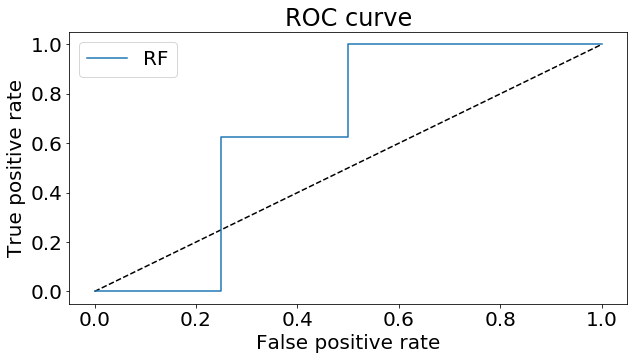


Confusion Matrix
[[2 2]
 [2 6]]

Classification Report
              precision    recall  f1-score   support

    no_trade       0.50      0.50      0.50         4
       trade       0.75      0.75      0.75         8

    accuracy                           0.67        12
   macro avg       0.62      0.62      0.62        12
weighted avg       0.67      0.67      0.67        12



In [6]:
# training Random Forest classifier
model =  RandomForestClassifier()
model.fit(x_tn, y_tn)

# Validation Set
data_vd = data.iloc[spl:].dropna()
x_vd, y_vd = data_vd[feats], data_vd['bin']

# Plot ROC curve
y_pr_rf = model.predict_proba(x_vd)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_vd, y_pr_rf)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_rf, tpr_rf, label='RF')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.legend(loc='best')
plt.show()

# Confusion Matrix and Classification Report
y_pr = model.predict(x_vd)
print('\nConfusion Matrix')
print(confusion_matrix(y_vd, y_pr, labels=[0, 1]))
print('\nClassification Report')
print(classification_report(y_vd, y_pr, target_names=['no_trade','trade']))


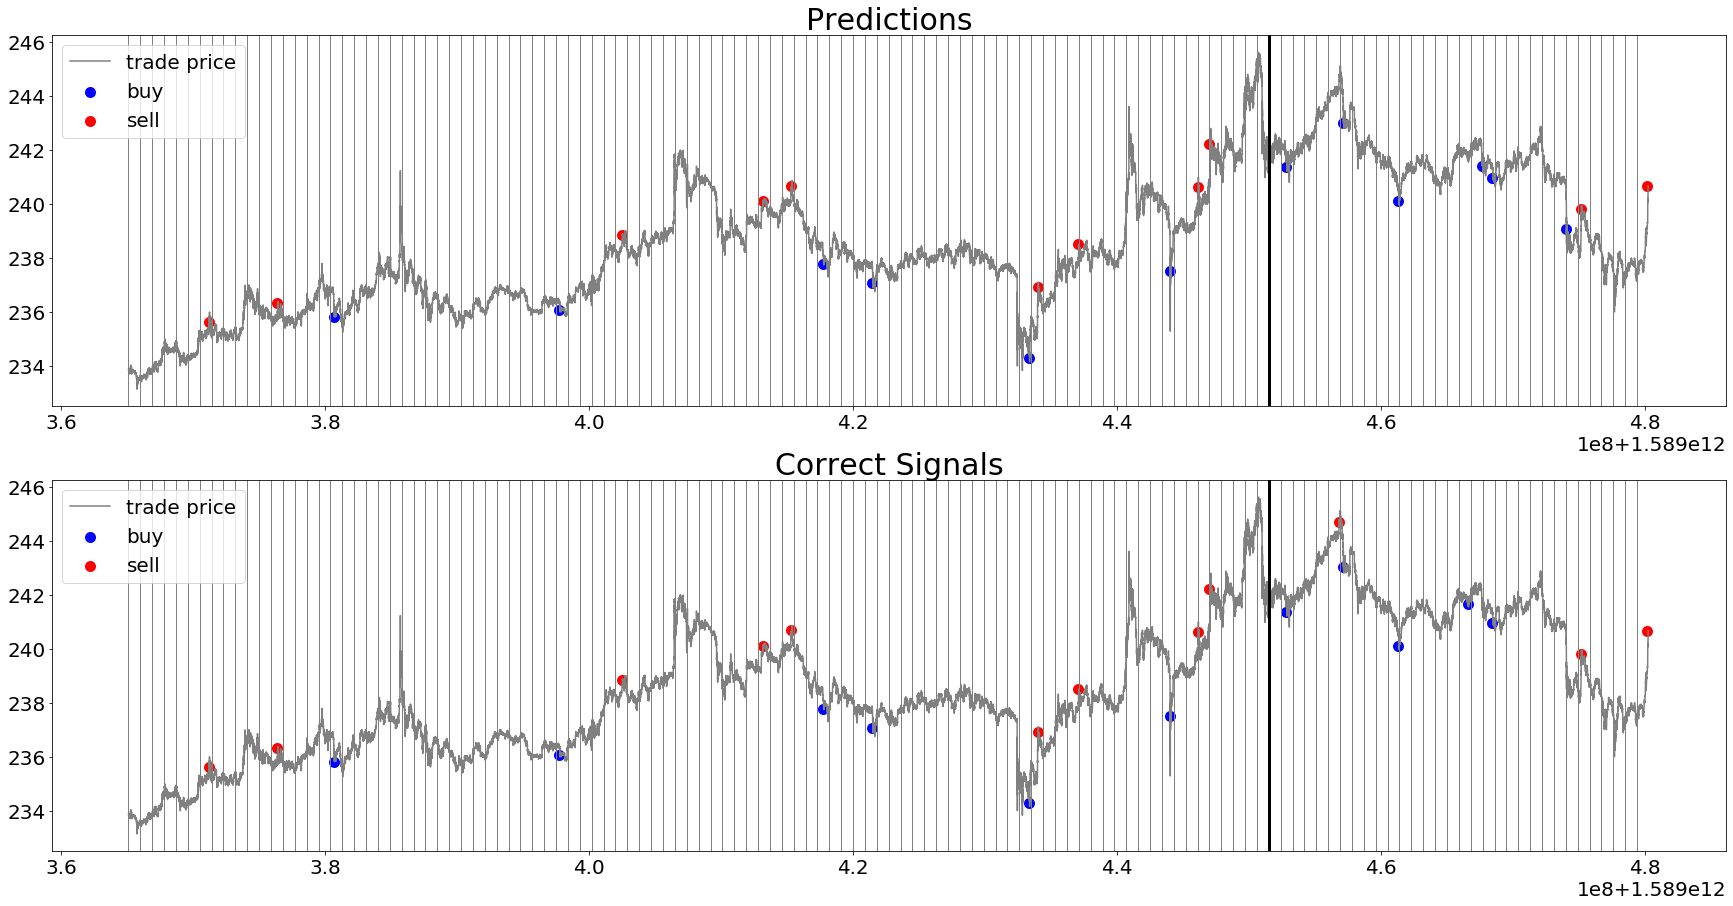

In [7]:
# Plot Correct signals vs Predicted signals
buy_pr = data[data['side']*model.predict(data[feats])==1]
sell_pr = data[data['side']*model.predict(data[feats])==-1]
buy = data[data['side']*data['bin']==1]
sell = data[data['side']*data['bin']==-1]

fig, axs = plt.subplots(2, figsize=(30, 15  ))
axs[0].set_title('Predictions', fontsize=30)
axs[0].plot(aggs['_t'], aggs['_p'], label='trade price', color='grey')
axs[0].scatter(buy_pr['_t'], buy_pr['_c'], label='buy', color='blue', linewidths=5)
axs[0].scatter(sell_pr['_t'], sell_pr['_c'], label='sell', color='red', linewidths=5)
for i in range(0, klns.shape[0], pd_es):
    axs[0].axvline(x=klns['_t'].iloc[i], linewidth=1, color='grey')
axs[0].axvline(x=klns['_t'].iloc[pd_tn], linewidth=3, color='black')
axs[0].legend()

axs[1].set_title('Correct Signals', fontsize=30)
axs[1].plot(aggs['_t'], aggs['_p'], label='trade price', color='grey')
axs[1].scatter(buy['_t'], buy['_c'], label='buy', color='blue', linewidths=5)
axs[1].scatter(sell['_t'], sell['_c'], label='sell', color='red', linewidths=5)
for i in range(0, klns.shape[0], pd_es):
    axs[1].axvline(x=klns['_t'].iloc[i], linewidth=1, color='grey')
axs[1].axvline(x=klns['_t'].iloc[pd_tn], linewidth=3, color='black')
axs[1].legend()
plt.show()

# 2/ Backtesting the Signals generated by RF Classifier

This part includes 3 steps:
1. Generate Signals objects based on the predictions of RF classifier
2. Generate Backtester object to calculate statistics of the trading session
3. Plot Trades entry/exit and Equity Curve. Print out Session Summary

a) Generate Signal objects

In [8]:
order_size = 100
model_signals = []
for i in range(data_vd.shape[0]):
    side = data_vd['side'].iloc[i]*y_pr[i]
    new_sig, startTime, price = None, data_vd['_t'].iloc[i]+60*1000, data_vd['_c'].iloc[i]
    expTime = startTime+60*2*1000
    stopLoss = atr
    takeProfit = atr
    timeLimit = 5*60
    if side==1.0:
        new_sig = Signal(symbol=symbol, side='BUY', size=order_size, orderType='MARKET', positionSide='LONG', price=price, \
                         startTime=startTime, expTime=expTime, stopLoss=stopLoss, takeProfit=takeProfit, timeLimit=timeLimit)
    elif side==-1.0:
        new_sig = Signal(symbol=symbol, side='SELL', size=order_size, orderType='MARKET', positionSide='SHORT', price=price, \
                         startTime=startTime, expTime=expTime, stopLoss=stopLoss, takeProfit=takeProfit, timeLimit=timeLimit)

    if new_sig is not None:
        model_signals.append(new_sig)

b) Generate Backtester object

In [9]:
tradeData = pd.DataFrame()
tradeData['_t'] = klns['_t'].iloc[pd_tn:] + 60*1000
tradeData['_p'] = klns['_c'].iloc[pd_tn:]

backtest = Backtester(symbol=symbol, tradeData=tradeData, initBalance=200, orderSize=order_size, signalList=[])
for sig in model_signals.copy():
    ready = False
    if len(backtest.signalList)==0: ready = True
    else:
        last_trade = backtest.signalList[-1]
        if sig.startTime > last_trade.clsTime: ready = True

    trades = aggs[aggs['_t']>=sig.startTime]
    if ready and (trades.shape[0] > 0):
        sig.set_active(excTime=trades['_t'].iloc[0], excPrice=trades['_p'].iloc[0], excQty=sig.get_quantity())
        _exit = False
        foundSL = False
        while not _exit:
            for i in range(1, trades.shape[0]):
                _t, _p = trades['_t'].iloc[i], trades['_p'].iloc[i]
                pos = SIDE[sig.side]*(_p - sig.excPrice)
                if pos <= -sig.stopLoss: foundSL = True
                if (pos >= sig.takeProfit or (foundSL and pos >= -0.5*sig.stopLoss)) or _t==trades['_t'].iloc[-1]:
                    _exit = True
                    sig.set_cnt_ordered(cntorderId=0, cntTime=_t, cntType='MARKET')
                    sig.set_closed(clsTime=_t, clsPrice=_p)
                    break
        backtest.add_signal(sig)

balance = pd.DataFrame(backtest.balance_update())


c) Plot Trades entry/exit and Equity Curve


##########################     Backtester Summary     ##########################


	Symbol: BCHUSDT
	Trading Time: 	7.98 h

	Gross Profit: 	1.01206
	Gross Loss: 	0.24128
	Commision: 	0.19200
	Net Profit: 	0.57878
	Total number of trades: 	6
	Number of win trades: 	4
	Number of loss trades: 	2
	Average time in position: 	6.28 mins


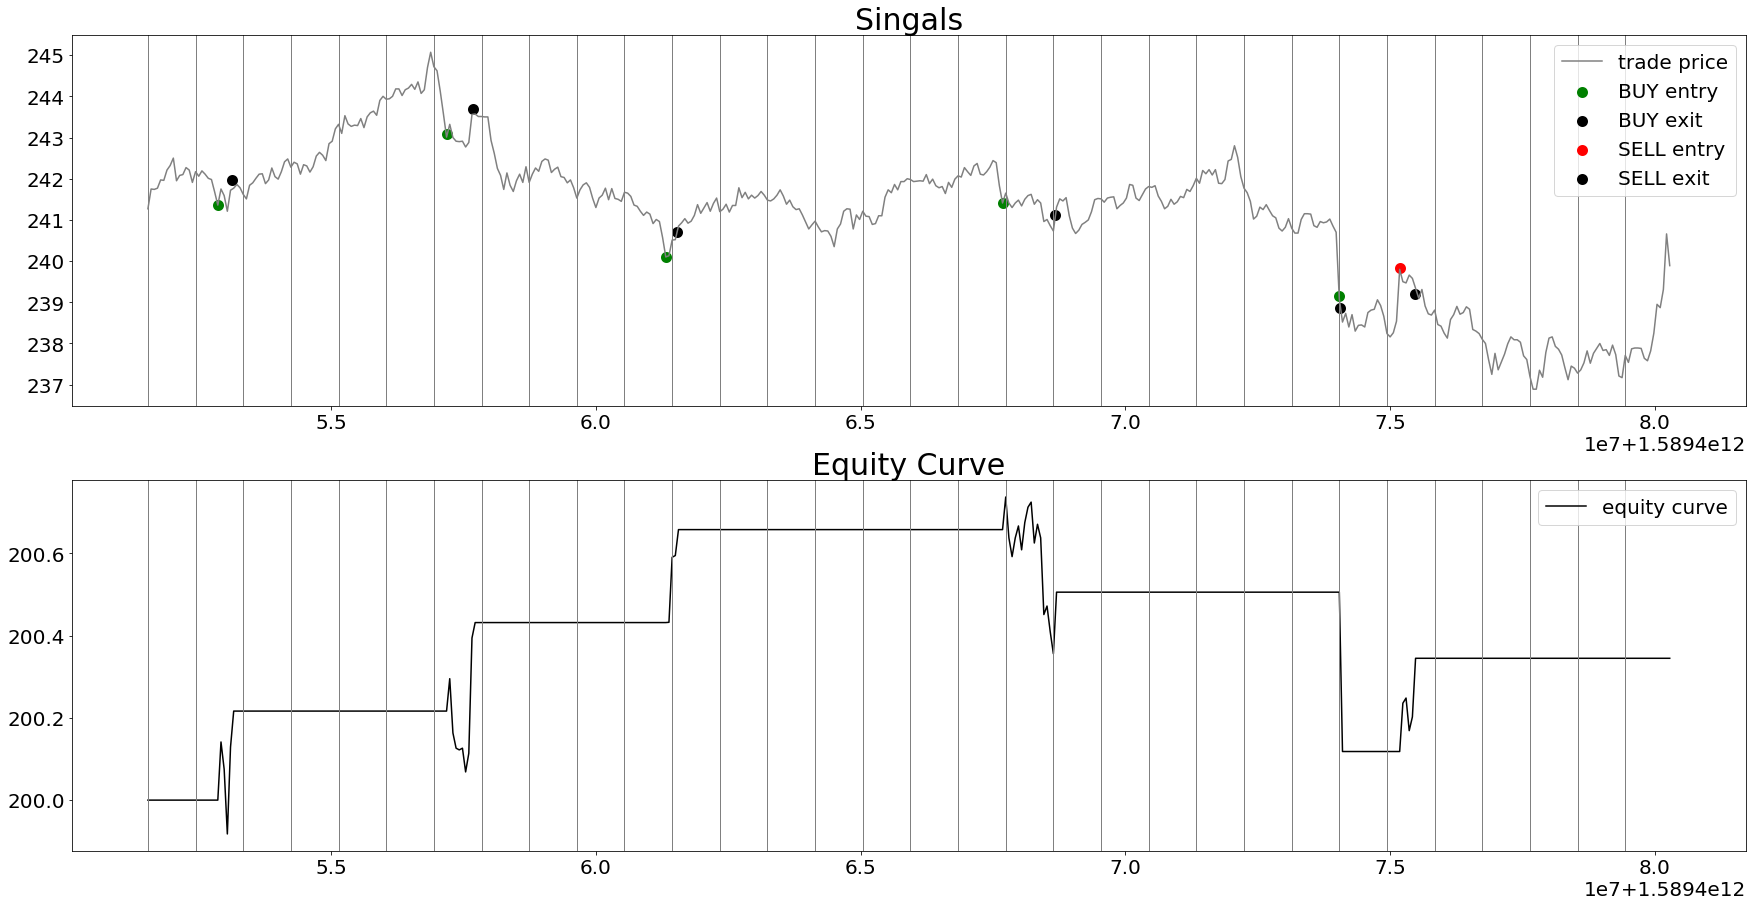

In [10]:
# Buy and Sell Trades from Backtester
buy = pd.DataFrame(columns=['excTime', 'excPrice', 'clsTime', 'clsPrice'])
sell = pd.DataFrame(columns=['excTime', 'excPrice', 'clsTime', 'clsPrice'])
for sig in backtest.signalList:
    if sig.side == 'BUY':
        buy = buy.append({'excTime': sig.excTime, 'excPrice': sig.excPrice, 'clsTime': sig.clsTime, 'clsPrice': sig.clsPrice}, ignore_index=True)
    else:
        sell = sell.append({'excTime': sig.excTime, 'excPrice': sig.excPrice, 'clsTime': sig.clsTime, 'clsPrice': sig.clsPrice}, ignore_index=True)

# Plot Trades entry/exit and Equity Curve
fig, axs = plt.subplots(2, figsize=(30, 15))
axs[0].set_title('Singals', fontsize=30)
axs[0].plot(tradeData['_t'], tradeData['_p'], label='trade price', color='grey')
axs[0].scatter(buy['excTime'], buy['excPrice'], label='BUY entry', color='green', linewidths=5)
axs[0].scatter(buy['clsTime'], buy['clsPrice'], label='BUY exit', color='black', linewidths=5)
axs[0].scatter(sell['excTime'], sell['excPrice'], label='SELL entry', color='red', linewidths=5)
axs[0].scatter(sell['clsTime'], sell['clsPrice'], label='SELL exit', color='black', linewidths=5)
for i in range(0, tradeData.shape[0], pd_es):
    axs[0].axvline(x=tradeData['_t'].iloc[i], linewidth=1, color='grey')
axs[0].legend()

axs[1].set_title('Equity Curve', fontsize=30)
axs[1].plot(balance['_t'], balance['_b'], label='equity curve', color='black')
for i in range(0, tradeData.shape[0], pd_es):
    axs[1].axvline(x=tradeData['_t'].iloc[i], linewidth=1, color='grey')
axs[1].legend()

backtest.summary()
